# Building model to classify 10 different ID cards
We want to build a sequential keras model, using tensorflow.

## Installing Dependencies

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from keras import layers
from keras.models import Sequential
from keras import regularizers


## Load images
We need to put the images of each class in seperate folder with appropriate name in `data` directory.


Using 20% of images as *test* set and the remaining 80% as *train* set. Resizing the images to `img_height`, `img_width`.
Also exporting `csv` file to use in backend app.

Found 1000 files belonging to 10 classes.
['alb_id', 'aze_passport', 'esp_id', 'est_id', 'fin_id', 'grc_passport', 'lva_passport', 'rus_internalpassport', 'srb_passport', 'svk_id']


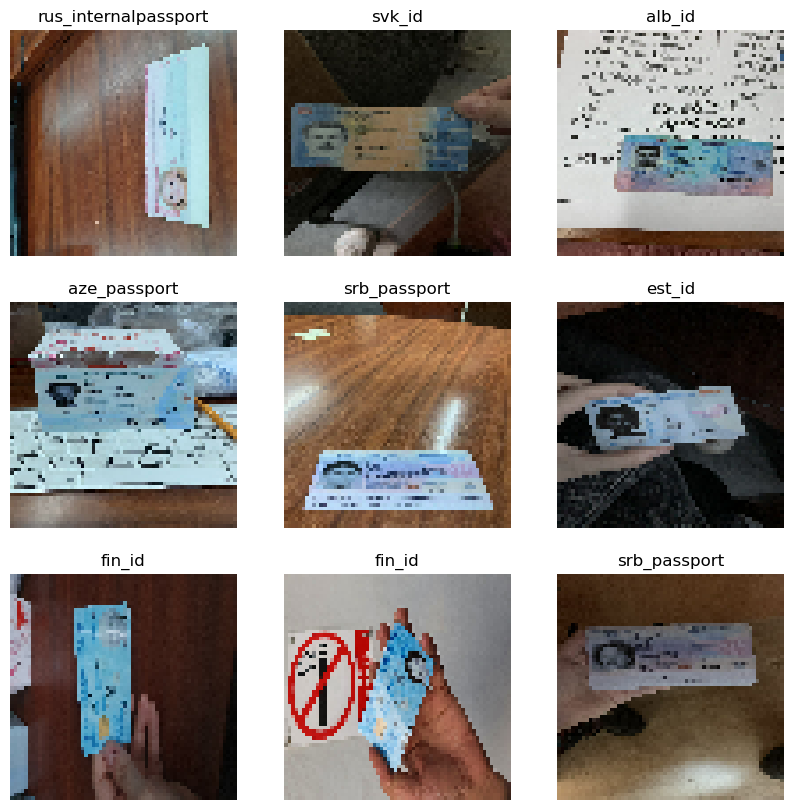

In [229]:
batch_size = 24
img_height = 128
img_width = 128

data = tf.keras.utils.image_dataset_from_directory('data', image_size=(img_height, img_width) , batch_size=batch_size)
class_names = data.class_names
print(class_names)
with open('backend/model/class_names.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write each class name on a new line
    for name in class_names:
        writer.writerow([name])
num_classes = len(class_names)

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")





## Create train, validation and test sets

In [235]:
data = data.map(lambda x,y: (x/255, y))
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


## Building the model
To prevent overfitting:
- Adding a layer to add random brightness change to input files
- Adding a layer to add random contrast 
- Adding a layer to add random rotation (as we expect different different alignment in images )
- Adding a Dense layer to regularize the input
- Adding a Dropout layer to prevent overfitting

- Add some more layer to our NN with `relu` activation as we have more than 2 classes.
- 


## Defining the metrics

In [259]:
import tensorflow_addons as tfa
model = Sequential()

# model.add(layers.RandomBrightness(0.2, input_shape=(img_height, img_width, 3)))
# model.add(layers.RandomContrast(0.2))
# model.add(layers.RandomRotation(0.2))


# model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Dense(64, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5), input_shape=(img_height, img_width, 3)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy",])

model.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 64, 64, 64)        256       
                                                                 
 dropout_22 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_204 (Conv2D)         (None, 64, 64, 16)        9232      
                                                                 
 max_pooling2d_204 (MaxPool  (None, 32, 32, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_205 (Conv2D)         (None, 32, 32, 64)        9280      
                                                                 
 max_pooling2d_205 (MaxPool  (None, 16, 16, 64)        0         
 ing2D)                                              

In [260]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
epochs = 20
history = model.fit(train, epochs=epochs, validation_data=val)


Epoch 1/20


/Users/anosrati/code/ml/.venv/lib/python3.11/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 [==============================] - 26s 791ms/step - loss: 2.3476 - accuracy: 0.0948 - val_loss: 2.3282 - val_accuracy: 0.0990
Epoch 2/20
29/29 [==============================] - 26s 822ms/step - loss: 2.3237 - accuracy: 0.1020 - val_loss: 2.3204 - val_accuracy: 0.0781
Epoch 3/20
29/29 [==============================] - 25s 807ms/step - loss: 2.3147 - accuracy: 0.1264 - val_loss: 2.3157 - val_accuracy: 0.0885
Epoch 4/20
29/29 [==============================] - 25s 789ms/step - loss: 2.3017 - accuracy: 0.1509 - val_loss: 2.3009 - val_accuracy: 0.0990
Epoch 5/20
29/29 [==============================] - 24s 754ms/step - loss: 2.2574 - accuracy: 0.1681 - val_loss: 2.2425 - val_accuracy: 0.2083
Epoch 6/20
29/29 [==============================] - 25s 788ms/step - loss: 2.0622 - accuracy: 0.2629 - val_loss: 2.0744 - val_accuracy: 0.2396
Epoch 7/20
29/29 [==============================] - 26s 803ms/step - loss: 1.8036 - accuracy: 0.3822 - val_loss: 1.8551 - val_accuracy: 0.3646
Epoch 8/20

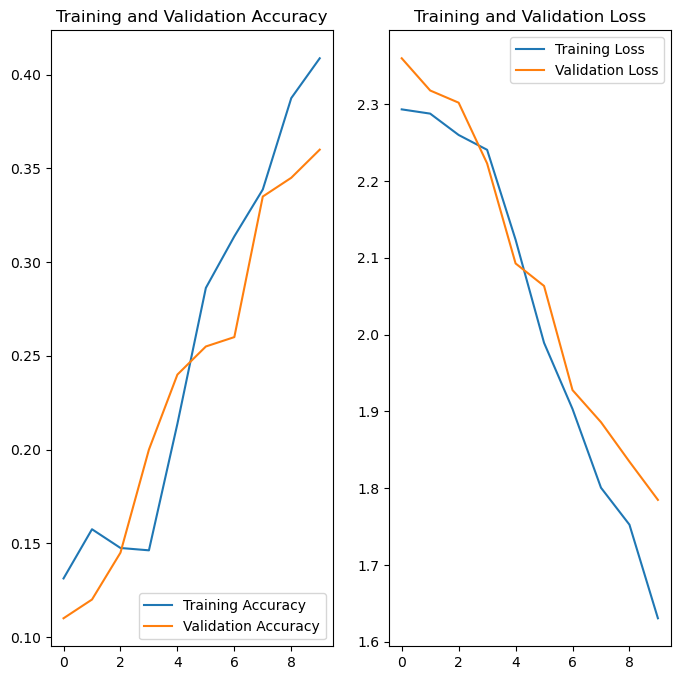

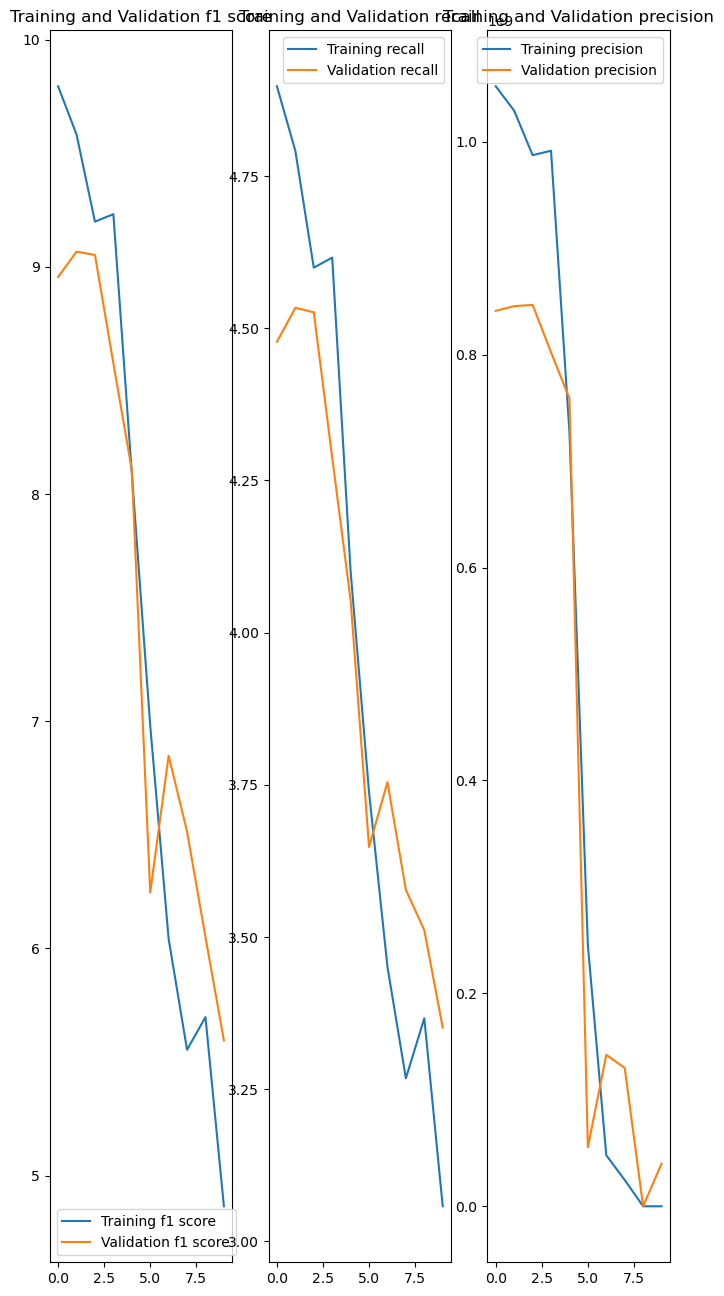

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

f1_m = history.history['f1_m']
val_f1_m = history.history['val_f1_m']

precision_m = history.history['precision_m']
val_precision_m = history.history['val_precision_m']

recall_m = history.history['recall_m']
val_recall_m = history.history['val_recall_m']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(8, 16))

plt.subplot(1,3 , 1)
plt.plot(epochs_range, f1_m, label='Training f1 score')
plt.plot(epochs_range, val_f1_m, label='Validation f1 score')
plt.legend(loc='lower left')
plt.title('Training and Validation f1 score')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, recall_m, label='Training recall')
plt.plot(epochs_range, val_recall_m, label='Validation recall')
plt.legend(loc='upper right')
plt.title('Training and Validation recall')


plt.subplot(1, 3, 3)
plt.plot(epochs_range, precision_m, label='Training precision')
plt.plot(epochs_range, val_precision_m, label='Validation precision')
plt.legend(loc='upper right')
plt.title('Training and Validation precision')



plt.show()



## Evaluate

In [255]:
def success_rate(data_set):
    success_rate = []
    for batch in data_set.as_numpy_iterator(): 
        X, y = batch
        yhat = model.predict(X)
        # print(X)
        pred_index = []
        for yh in yhat:
            pred_index.append(yh.argmax(axis=-1))
        # print(y)
        # print(np.array(pred_index))
        correct_pred = 0
        for i in range(len(y)):
            if y[i] == pred_index[i]:
                correct_pred += 1
        # print("correct_preds: ", correct_pred)
        # print("failed_preds: ", len(y) - correct_pred)
        print("count", len(y),"success rate: ", correct_pred/len(y))
        success_rate.append(correct_pred/len(y))

    average_success_rate = np.sum(success_rate)/len(success_rate)
    return average_success_rate

In [261]:
print("Training success rate: ", success_rate(train))


1/1 [==============================] - 0s 98ms/step
count 24 success rate:  0.875
1/1 [==============================] - 0s 47ms/step
count 24 success rate:  0.9583333333333334
1/1 [==============================] - 0s 42ms/step
count 24 success rate:  1.0
1/1 [==============================] - 0s 38ms/step
count 24 success rate:  1.0
1/1 [==============================] - 0s 64ms/step
count 24 success rate:  1.0
1/1 [==============================] - 0s 54ms/step
count 24 success rate:  0.9583333333333334
1/1 [==============================] - 0s 37ms/step
count 24 success rate:  1.0
1/1 [==============================] - 0s 38ms/step
count 24 success rate:  1.0
1/1 [==============================] - 0s 30ms/step
count 24 success rate:  0.9583333333333334
1/1 [==============================] - 0s 35ms/step
count 24 success rate:  1.0
1/1 [==============================] - 0s 53ms/step
count 24 success rate:  1.0
1/1 [==============================] - 0s 29ms/step
count 24 success rate

In [262]:
print("Validation success rate: ", success_rate(val))


1/1 [==============================] - 0s 28ms/step
count 24 success rate:  0.875
1/1 [==============================] - 0s 38ms/step
count 24 success rate:  0.75
1/1 [==============================] - 0s 28ms/step
count 24 success rate:  0.7916666666666666
1/1 [==============================] - 0s 36ms/step
count 24 success rate:  0.625
1/1 [==============================] - 0s 20ms/step
count 24 success rate:  0.6666666666666666
1/1 [==============================] - 0s 21ms/step
count 24 success rate:  0.625
1/1 [==============================] - 0s 21ms/step
count 24 success rate:  0.625
1/1 [==============================] - 0s 20ms/step
count 24 success rate:  0.6666666666666666
Validation success rate:  0.703125


In [263]:
print("Test success rate: ", success_rate(test))

1/1 [==============================] - 0s 20ms/step
count 24 success rate:  0.6666666666666666
1/1 [==============================] - 0s 21ms/step
count 24 success rate:  0.5833333333333334
1/1 [==============================] - 0s 20ms/step
count 24 success rate:  0.75
1/1 [==============================] - 0s 20ms/step
count 24 success rate:  0.625
Test success rate:  0.65625


## Save

In [264]:

model.save('backend/model/id-classification.h5')


/Users/anosrati/code/ml/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
